## 1. Introduction

The Emergency and Security Coordinating Centre (CECOES 1-1-2) performs the coordination of different resources available in the Canary Islands relating to emergencies, among others, the Canary Islands Emergency Service (SUC), Emergency and Rescue Group (GES), the different police forces (Local Police, National Police and Civil Guard), the Fire Service and the Domestic Violence Service. The next chart shows the different coordinated services.

<img src="cecoes.png" alt="CECOES 1-1-2" style="width:604px;height:328px;">

The prediction of incidents represents an important issue for emergency services organisations in order to accurately forecast the daily number of alerts by municipality, explain seasonal patterns in the frequency of incidents or even detect unusual events in historical records.

## 2. Forecasting the Number of Incidents using Time Series Models

The data series of emergency and security incidents are characterized by multiple seasonal patterns. 
We consider the following dynamic harmonic regression model and we fit to the daily incident data over the five years from 1 January 2010 to 31 December 2014 with an annual calendar
seasonal effect period of 365.25 [(see De Livera, 2011)](#de_livera2)

\begin{align*}
&\begin{aligned}\label{eq:arima}
y_t = \gamma x_t + & \sum_{k=1}^K \left\{ \alpha_k \sin\left(\frac{2\pi k t}{m}\right) + \beta_k \cos\left(\frac{2\pi k t}{m}\right) \right\} + \eta_t \\
\end{aligned}\\
&\begin{aligned}
& \phi(B)\nabla^d \eta_t=\theta(B) z_t
\end{aligned}
\end{align*}

where $y_t$ is the observation of the number of incidents in time $t$ expressed in dynamic harmonic regression of sums of Fourier terms, for $k=1,..,K$, that model the periodic
seasonality and $m$ is the period of the seasonal cycle. The optimal value of $K$ can be obtained by minimizing the corrected Akaike Information Criterion, AICc. In the model, the covariate $x_t$ is used to incorporate the calendar effect of changing public holidays and weekends in the frequency of incidents (compared to working days). The error component $\eta_t$ is modelled as a non-seasonal ARIMA(p,d,q), where $\phi\left(\cdot\right)$ and $\theta\left(\cdot\right)$ 
are the corresponding autorregresive and moving average polynomials of orders $p$ and $q$ respectively, $d$ represents the order of the differencing and $z_t$ are the Gaussian white noise process with zero mean and constant variance $\sigma^2$.


The above regression time series model with ARIMA errors assume that the seasonality is fixed and does not change over time. We  consider the alternative model TBATS to fit this complexity in seasonality patterns. TBATS is an acronym for the key features of the time series model proposed by [De Livera, 2010](#de_livera1), that is, an exponential smoothing method with Trigonometric seasonal + Box-Cox transformation + ARMA model for residuals + Trend and Seasonal components


\begin{aligned}\label{eq:tbats1}
&y_t^{(\lambda)} = l_{t-1} + \varphi b_{t-1} + \sum_{i=1}^T s_{t-m_i}^{(i)} + \eta_t \\ 
&l_t = l_{t-1} + \varphi b_{t-1} + \alpha \eta_t \\ 
&b_t = (1-\varphi)b + \varphi b_{t-1} + \beta \eta_t \\ 
&s_{t}^{(i)} = s_{t-m_i}^{(i)} + \gamma_i \eta_t\\
&\phi(B)\nabla^d \eta_t=\theta(B) z_t
\end{aligned}

where $y_t^{\left(\lambda\right)}$ represents the Box-Cox transformed observation with  parameter $\lambda$ at time $t$, that is 

\begin{aligned}\label{eq:boxcox}
&y_t^{(\lambda)} = \left\{
\begin{array}{ll}
      \frac{y_t^\lambda-1}{\lambda}, & \lambda \neq 0, \\
      \log{y_t}, & \lambda = 0, 
\end{array} 
\right.
\end{aligned}

and $m_1,...,m_T$ denote the seasonal periods, $l_t$ is the local level in period $t$, $b$ and $b_t$ are the long and short-run trends in period $t$, respectively, and $\varphi$ is the parameter of the damped trend. Denoting $T$ as the total number of time values, the $i$th seasonal components at time $t$ in the model, for $i=1,...,T$, are given by $s_t^{(i)}=\sum_{j=1}^{K_i}s_{j,t}^{(i)}$, where

\begin{aligned}\label{eq:tbats2}
&s_{j,t}^{(i)} = s_{j,t-1}^{(i)}\cos\left(\frac{2\pi j}{m_i}\right) + s_{j,t-1}^{*(i)}\sin\left(\frac{2\pi j}{m_i}\right)+ \delta_1^{(i)} \eta_t  \\
&s_{j,t}^{*(i)} = -s_{j,t-1}\sin\left(\frac{2\pi j}{m_i}\right) + s_{j,t-1}^{*(i)}\cos\left(\frac{2\pi j}{m_i}\right)+ \delta_2^{(i)} \eta_t  \\
\end{aligned}

with $K_i$ the number of harmonics in the $i$th seasonal component. As in the previous model, $\eta_t$ and $z_t$ are a non-seasonal ARMA($p$,$q$) process and a Gaussian white noise process with zero mean and constant variance $\sigma^2$, respectively. The smoothing parameters are given by $\alpha, \beta, \gamma, \delta_1^{\left(i\right)}$ and $\delta_2^{\left(i\right)}$. 

### 2.1 Illustrative example

We have included two .RData files with this notebook including the number of incidents from January, 2013 to January, 2015 in two municipalities of Canary Islands:
* La Orotava, in Tenerife; this file is called 'serie1_orotava.RData', 
* and Telde, in Las Palmas; in this case, the file is 'serie1_telde.RData'. 

Both files can be loaded in this notebook by using the load() command. Before to fit the models, we need load several libraries (the libraries must be installed if they are not available) 


In [2]:
#install.packages("dplyr","forecast","ggplot2","zoo","scales")
require(dplyr)
require(forecast)
require(ggplot2)
require(zoo)
require(scales)
options(repr.plot.width=8, repr.plot.height=4)

### 2.1.1 Dynamic harmonic regression with ARIMA errors

In this sub-section, we are going to fit the daily number of incidents in Telde from January, 2013 to December, 2014 using the dynamic harmonic regression and predict the incidents in January, 2015. Then, we load this dataset and we filter the observed values in the time interval 

In [3]:
load("serie1_telde.RData")

In [4]:
serie2_full<-subset(serie1, date >= strftime('2013-01-01', format = '%Y-%m-%d') & date <= strftime('2015-01-31', format = '%Y-%m-%d'))
serie2_full <- ts(serie2_full$N, frequency=365.25, start=c(2013,1,1))

serie2_days<-day_df[day_df$date>="2013-01-01" & day_df$date<="2015-01-31",]
serie2_days$time<-round(time(serie2_full),3)


We filter the observations (two complete years, 2013 and 2014) to be used in fitting the Fourier terms to model the periodic seasonality for a given value of $K$

In [5]:
K<-12
serie2_hist<-subset(serie1, date >= strftime('2013-01-01', format = '%Y-%m-%d') & date <= strftime('2014-12-31', format = '%Y-%m-%d'))
serie2_fourier  <- fourier(ts(serie2_hist$N, frequency=365.25), K=K)
serie2_fourier_pred <- fourier(ts(serie2_hist$N, frequency=365.25), K=K, h=31)

We fit the model using auto.arima() function and, then, we predict the incidents of January, 2015, in Telde

In [6]:
serie2_fit <- auto.arima(ts(serie2_hist$N, frequency=365.25, start=c(2013,1,1)), 
                  xreg=cbind(serie2_fourier,serie2_hist$fest), seasonal=TRUE,parallel=TRUE,stepwise=FALSE)
day_fest<-day_df$fest[day_df$date>="2015-01-01" & day_df$date<="2015-01-31"]
serie2_predict<- forecast(serie2_fit, xreg=cbind(serie2_fourier_pred,day_fest), h=31, level=95)

Warning message in value[[3L]](cond):
"The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data."

We create a data.frame with the predicted values and the confidence intervals to be plotted

In [7]:
serie2_plot<-funggcast(serie2_full,serie2_predict,serie2_days)
serie2_plot<-serie2_plot[serie2_plot$date>="2014-10-28",]

Warning message:
"Removed 31 rows containing missing values (geom_path)."Warning message:
"Removed 65 rows containing missing values (geom_path)."

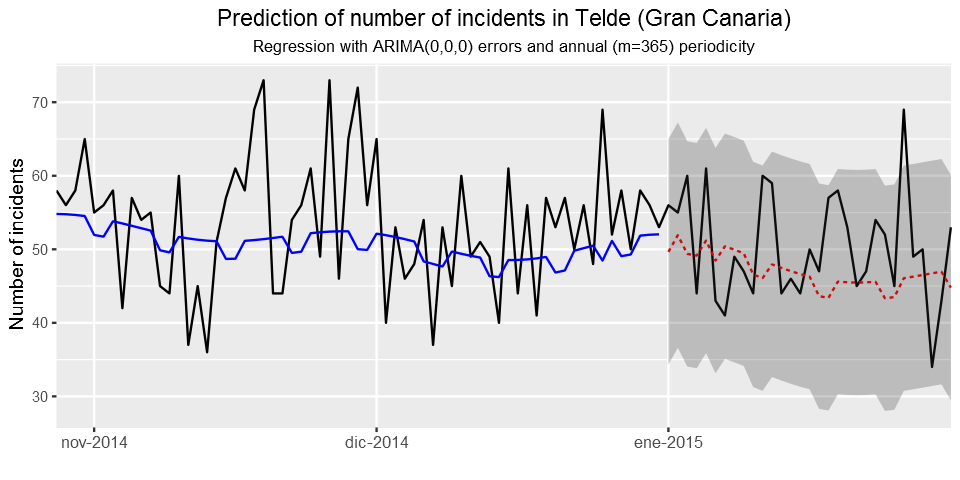

In [8]:
arma_chart<-ggplot(data=serie2_plot,aes(x=date,y=observed)) +
     geom_line(col='black') +
     geom_line(aes(y=fitted),col='blue') +
     geom_line(aes(y=forecast),col='red',lty=2)+geom_ribbon(aes(ymin=lo95,ymax=hi95),alpha=.25) +
     scale_x_date(name='',date_breaks='1 month',date_minor_breaks='1 month',labels=date_format("%b-%Y"),expand=c(0,0)) +
     scale_y_continuous(name='Number of incidents') +
     theme(axis.text.x=element_text(size=10),plot.title=element_text(hjust = 0.5),plot.subtitle=element_text(hjust = 0.5)) + 
     labs(title='Prediction of number of incidents in Telde (Gran Canaria)',
          subtitle=bquote('Regression with ARIMA('*.(serie2_fit$arma[1])*','*.(serie2_fit$arma[6])*','*.(serie2_fit$arma[2])*') errors and annual (m=365) periodicity' ))

arma_chart

We can evaluate the model residuals by obtaining the following additional results

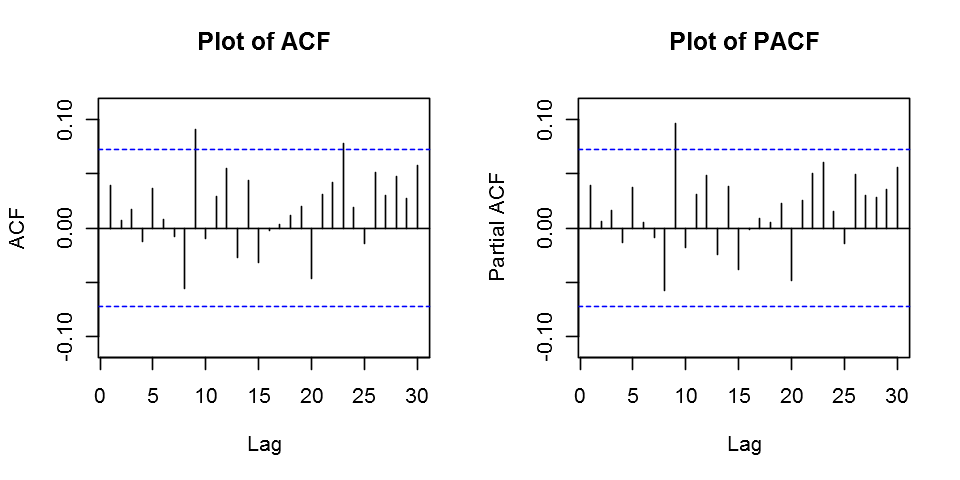

In [9]:
# model residuals can be considered a white noise, with almost all the spikes non significant except the lag 9 (only 1 out of the first 30 lags)
par(mfrow=c(1,2))
Acf(resid(serie2_fit),lag.max = 30,main="Plot of ACF")
Pacf(resid(serie2_fit),lag.max=30,main="Plot of PACF")

In [10]:
# The Ljung-Box test shows that there is not evidence of dependent residuals at lags 1-50
Box.test(resid(serie2_fit), lag=50, type="Ljung-Box")


	Box-Ljung test

data:  resid(serie2_fit)
X-squared = 58.27, df = 50, p-value = 0.1973


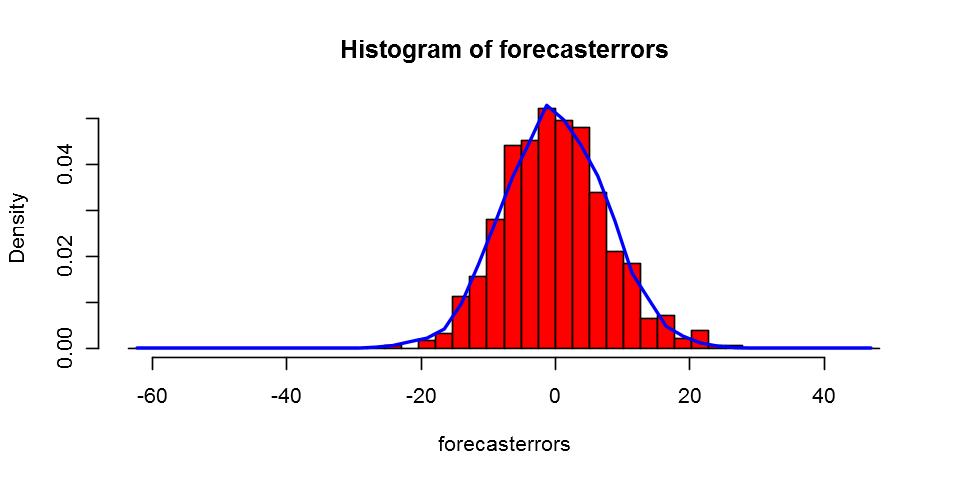

In [11]:
#Function to check whether forecast errors are normally distributed with mean zero
#(code source extracted from https://a-little-book-of-r-for-time-series.readthedocs.io/en/latest/src/timeseries.html)
plotForecastErrors <- function(forecasterrors)
{
  # make a histogram of the forecast errors:
  mybinsize <- IQR(forecasterrors,na.rm=TRUE)/4
  mysd   <- sd(forecasterrors,na.rm=TRUE)
  mymin  <- min(forecasterrors,na.rm=TRUE) - mysd*5
  mymax  <- max(forecasterrors,na.rm=TRUE) + mysd*3
  # generate normally distributed data with mean 0 and standard deviation mysd
  mynorm <- rnorm(10000, mean=0, sd=mysd)
  mymin2 <- min(mynorm)
  mymax2 <- max(mynorm)
  if (mymin2 < mymin) { mymin <- mymin2 }
  if (mymax2 > mymax) { mymax <- mymax2 }
  # make a red histogram of the forecast errors, with the normally distributed data overlaid:
  mybins <- seq(mymin, mymax, mybinsize)
  hist(forecasterrors, col="red", freq=FALSE, breaks=mybins)
  # freq=FALSE ensures the area under the histogram = 1
  # generate normally distributed data with mean 0 and standard deviation mysd
  myhist <- hist(mynorm, plot=FALSE, breaks=mybins)
  # plot the normal curve as a blue line on top of the histogram of forecast errors:
  points(myhist$mids, myhist$density, type="l", col="blue", lwd=2)
}

#The residuals are normally distributed with mean zero.
plotForecastErrors(resid(serie2_fit))

### 2.1.2 TBATS model

Now, we consider TBATS model to fit the incidents data series in La Orotava from January, 2013 to December, 2014 for predicting the incidents in January, 2015. Again, we load this dataset and we filter the observed values in the time interval

In [12]:
load("serie1_orotava.RData")

In [13]:
serie2_full<-subset(serie1, date >= strftime('2010-01-01', format = '%Y-%m-%d') & date <= strftime('2015-01-31', format = '%Y-%m-%d'))
serie2_full <- ts(serie2_full$N, frequency=365.25, start=c(2010,1,1))

serie2_days<-day_df[day_df$date>="2010-01-01" & day_df$date<="2015-01-31",]
serie2_days$time<-round(time(serie2_full),3)


We filter the observations (from 2010 to 2014) to fit the TBATS model by using tbats() function and predict the incidents in January, 2015

In [14]:
serie2_hist<-subset(serie1, date >= strftime('2010-01-01', format = '%Y-%m-%d') & date <= strftime('2014-12-31', format = '%Y-%m-%d'))
serie2_tbats <- tbats(ts(serie2_hist$N, frequency=365.25, start=c(2010,1,1)),
                      seasonal.periods = c(7,30.4,365.25), use.parallel=TRUE, num.cores = 2)


In the following, we create a data.frame with the predicted values and the confidence intervals to be plotted

In [15]:
serie2_predict <- forecast(serie2_tbats, h=30)
serie2_plot<-funggcast(serie2_full,serie2_predict,serie2_days)
serie2_plot<-serie2_plot[serie2_plot$date>="2014-10-28",]


Warning message:
"Removed 30 rows containing missing values (geom_path)."Warning message:
"Removed 65 rows containing missing values (geom_path)."

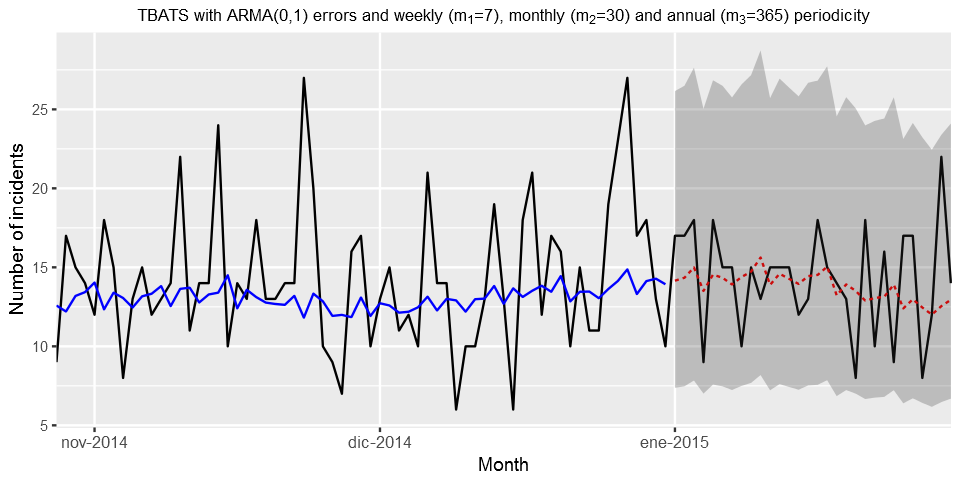

In [16]:
tbats_chart<-ggplot(data=serie2_plot,aes(x=date,y=observed)) +
     geom_line(col='black') +
     geom_line(aes(y=fitted),col='blue') +
     geom_line(aes(y=forecast),col='red',lty=2)+
     geom_ribbon(aes(ymin=lo95,ymax=hi95),alpha=.25)+
     scale_x_date(name='Month',date_breaks='1 month',date_minor_breaks='1 month',labels=date_format("%b-%Y"),expand=c(0,0))+
     scale_y_continuous(name='Number of incidents')+
     theme(axis.text.x=element_text(size=10),plot.title=element_text(hjust = 0.5),plot.subtitle=element_text(hjust = 0.5)) + 
     labs(subtitle=bquote('TBATS with ARMA('*.(serie2_tbats$p)*','*.(serie2_tbats$q)*') errors and weekly ('*m[1]*'=7), monthly ('*m[2]*'=30) and annual ('*m[3]*'=365) periodicity' ))

tbats_chart

We can obtain additional results to evalaute the fitted model

    observed          level          season1              season2          
 Min.   :0.7168   Min.   :2.706   Min.   :-9.657e-02   Min.   :-7.232e-02  
 1st Qu.:2.5777   1st Qu.:2.834   1st Qu.:-1.680e-02   1st Qu.:-1.921e-02  
 Median :2.9093   Median :2.881   Median : 2.791e-03   Median :-2.576e-03  
 Mean   :2.8880   Mean   :2.883   Mean   : 2.690e-06   Mean   :-7.510e-06  
 3rd Qu.:3.1778   3rd Qu.:2.943   3rd Qu.: 1.696e-02   3rd Qu.: 1.922e-02  
 Max.   :5.3325   Max.   :3.037   Max.   : 9.023e-02   Max.   : 6.604e-02  
    season3          
 Min.   :-0.1672580  
 1st Qu.:-0.0682932  
 Median : 0.0033291  
 Mean   :-0.0006452  
 3rd Qu.: 0.0603860  
 Max.   : 0.1725743  

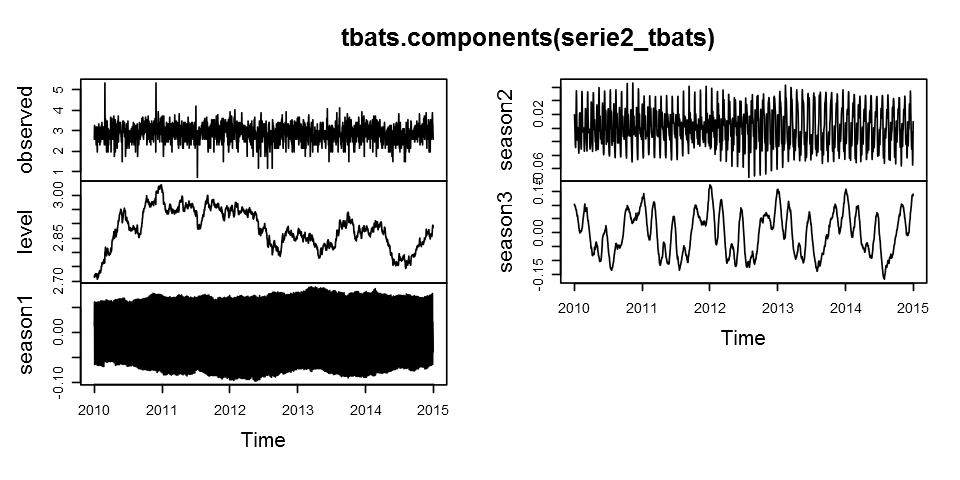

In [17]:
# time series decompositon of TBATS model into the different components
summary(tbats.components(serie2_tbats))
plot(tbats.components(serie2_tbats))

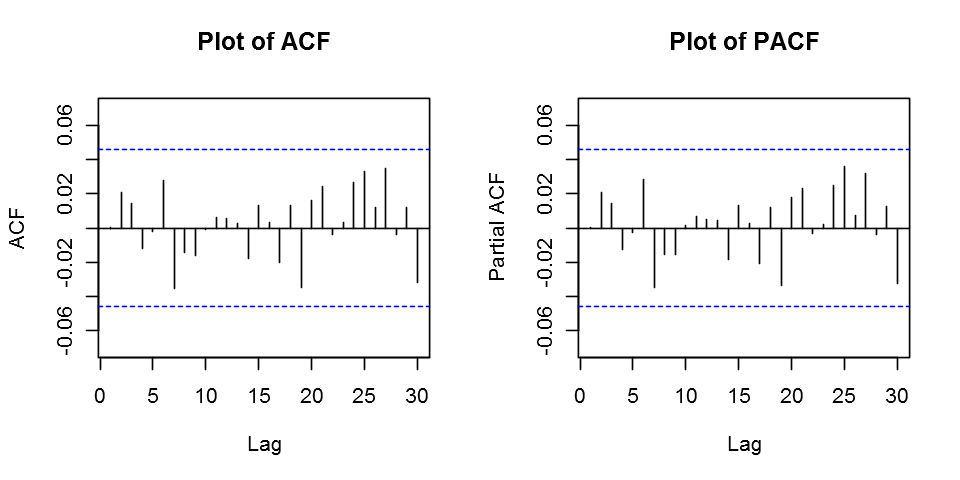

In [18]:
# model residuals can be considered a white noise
par(mfrow=c(1,2))
Acf(resid(serie2_tbats),lag.max = 30,main="Plot of ACF")
Pacf(resid(serie2_tbats),lag.max=30,main="Plot of PACF")


	Box-Ljung test

data:  resid(serie2_tbats)
X-squared = 43.52, df = 50, p-value = 0.7294


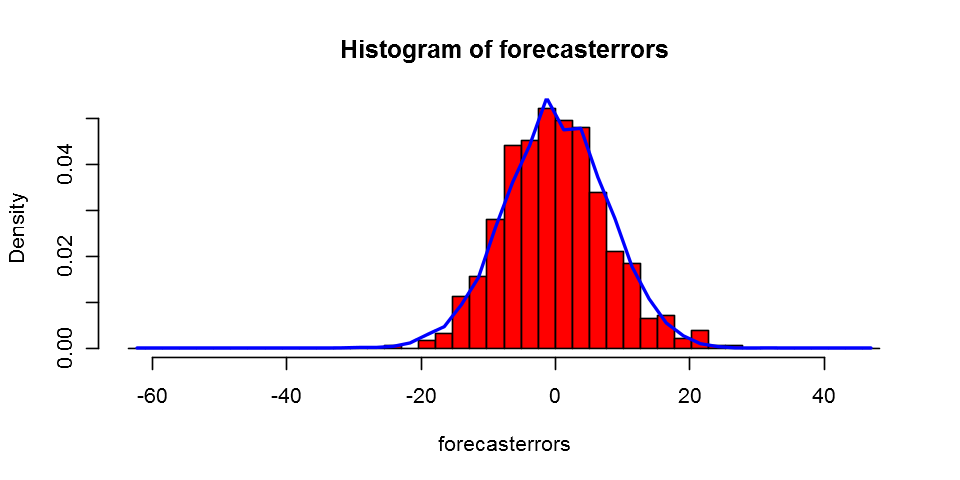

In [19]:
# The Ljung-Box test shows that there is not evidence of dependent residuals at lags 1-50
Box.test(resid(serie2_tbats), lag=50, type="Ljung-Box")
# The residuals are normally distributed with mean zero.
plotForecastErrors(resid(serie2_fit))

## 3. Predicting the Medical Incidents using Classification Models

We demonstrate how to perform a classification of incidents by using the "mlr" package, see [Bischl, 2016](#bischl). The main goal of "mlr" is to provide a unified interface for machine learning tasks as classification, regression, cluster analysis and survival analysis in R. In this package are implemented the methods to carry out standard methods like cross-validation and hyperparameter tuning for different learners. A tutorial of "mlr" can be found in https://mlr-org.github.io/mlr/articles/mlr.html.


In [21]:
#install.packages("mlr","parallel","rpart","rpart.utils","rpart.plot","xgboost","ranger")
library("mlr")
library("parallel")
library("rpart")
library("rpart.utils")
library("rpart.plot")
library("dplyr")
library("xgboost")
library("ranger")

### 3.1 Illustrative example

We are going to train classification models for predicting the medical incidents in "El Hierro" island. We have the following variables:

* MUNICIPALITY: the name of the municipality (88 values).
* MONTH: the month number, i.e. 1 (January) to 12 (December).
* DAY: the day within the month.
* HOUR: the hour of the day, i.e. 00:00 to 23:00.
* WEEK: a derived feature that holds the number of week in the month for any given day. For instance, days 1 to 7 fall in the first week, days 8-14 in the second, and so on.
* TIME: a derived feature that groups the variable HOUR into four daily quarters (00:00-753 05:59, 06:00-11:59, 12:00-17:59, 8:00-23:59).
* MEDICAL: a derived variable with true value ("M") if it is a medical emergency, and false value ("Not M") otherwise.
* N MEDICAL: a derived variable that counts the number of incidents with identical values in the previous variables.

The MEDICAL is the target variable for the prediction in the classification model. In this case, we load the file 'data1_el_hierro.RData' with these variables.

In [22]:
load("data1_el_hierro.RData")

In [23]:
year_min = 2005
year_max = 2014

training = subset(data.tree, YEAR >= year_min & YEAR < year_max)  %>%
  group_by(MONTH, DAY, HOUR, TIME, WEEK, MUNICIPALITY, ISLAND, SANITARY) %>%
  summarise(N_MEDICAL = n()) %>%
  as.data.frame()
testing = subset(data.tree, YEAR >= year_max) %>%
  group_by(MONTH, DAY, HOUR, TIME, WEEK, MUNICIPALITY, ISLAND, SANITARY) %>%
  summarise(N_MEDICAL = n()) %>%
  as.data.frame()

training = droplevels(training)
testing = droplevels(testing)
training$ISLAND = NULL
testing$ISLAND = NULL

#checking training
table.training = table(training$SANITARY)
# getting proportion of classes
cat("Prop. classes in training set:")
prop.table(table.training)

# checking testing
table.testing = table(testing$SANITARY)
# getting proportion of classes
cat("Prop. classes in testing set:")
prop.table(table.testing)


Prop. classes in training set:


        M     Not_M 
0.4516644 0.5483356 

Prop. classes in testing set:


        M     Not_M 
0.4418605 0.5581395 

In [24]:
# define tasks
SANITARY.y = "SANITARY"
MED = "M"
NOT_MED = "Not_M"

mlr.task.training = makeClassifTask(
  data = training,
  target = "SANITARY", 
  positive = MED
)

mlr.task.testing = makeClassifTask(
  data = testing, 
  target = "SANITARY",
  positive = MED
)

mlr.training.ohe = createDummyFeatures(
  training,
  target = SANITARY.y
)

mlr.testing.ohe = createDummyFeatures(
  testing,
  target = SANITARY.y
)

mlr.task.training.ohe = makeClassifTask(
  data = mlr.training.ohe,
  target = "SANITARY", 
  positive = MED
)

mlr.task.testing.ohe = makeClassifTask(
  data = mlr.testing.ohe, 
  target = "SANITARY",
  positive = MED
)

mlr.resamp = makeResampleDesc(
  method = "CV", 
  iters = 5L
)

mlr.control = makeTuneControlGrid()

#### 3.1.1 Classication Tree (learner "rpart")

In [25]:
#define learner
mlr.learner.rpart = makeLearner(
  "classif.rpart", 
  predict.type = "prob",
  cp = 0.00445
)


In [26]:
#model fitting and predicting
training.model = mlr::train(mlr.learner.rpart, mlr.task.training)
mlr.predict = predict(training.model, mlr.task.testing)


Warning message:
"Cannot retrieve the data used to build the model (so cannot determine roundint and is.logical for the variables).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE."

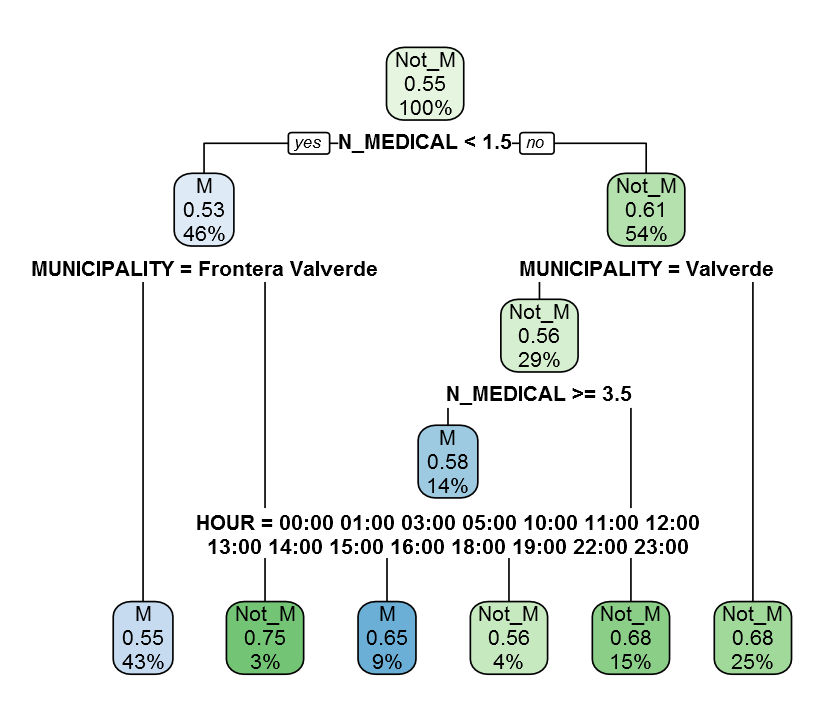

In [32]:
options(repr.plot.width=7, repr.plot.height=6)
#decision tree
split.fun <- function(x, labs, digits, varlen, faclen) {
  # replace commas with spaces (needed for strwrap)
  labs <- gsub(",", " ", labs)
  for(i in 1:length(labs)) {
    # split labs[i] into multiple lines
    labs[i] <- paste(strwrap(labs[i], width = 50), collapse = "\n")
  }
  labs
}

rpart.plot(getLearnerModel(training.model),
           type = 2,
           extra = 108,
           fallen.leaves = T, 
           split.fun = split.fun
           )

        predicted
true       M Not_M -err.-
  M      997   447    447
  Not_M  593  1231    593
  -err.- 593   447   1040
       predicted
true    M         Not_M                        
  M     997       447       tpr: 0.69 fnr: 0.31
  Not_M 593       1231      fpr: 0.33 tnr: 0.67
        ppv: 0.63 for: 0.27 lrp: 2.12 acc: 0.68
        fdr: 0.37 npv: 0.73 lrm: 0.46 dor: 4.63


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio
      acc       tpr       tnr        f1       auc 
0.6817625 0.6904432 0.6748904 0.6572182 0.6744585 


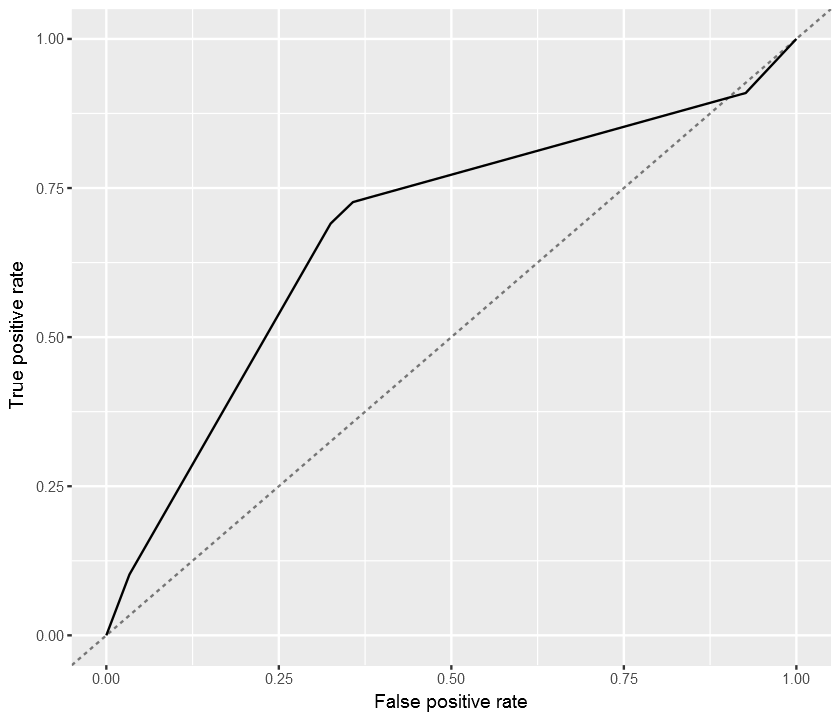

In [33]:
perf_ROC(mlr.predict)

#### 3.1.2 Extreme Gradient Boosting (learner "xgboost")

In [39]:
mlr.learner.xgb = makeLearner(
  "classif.xgboost",
  predict.type = "prob",
  objective = "binary:logistic",
  print_every_n = 100,
  verbose = 1,
  early_stopping_rounds = 10,
  eval_metric = "auc",
  nrounds = 300,
  subsample = 1, #0.8,
  colsample_bytree = 1, #0.8,
  eta = 0.01,
  gamma = 0.5, #1, # default 0
  max_depth = 6,
  nthread = detectCores() - 1
)

[1]	train-auc:0.675031 
Will train until train_auc hasn't improved in 10 rounds.

[101]	train-auc:0.692826 
[201]	train-auc:0.700526 
[300]	train-auc:0.707557 
        predicted
true       M Not_M -err.-
  M      961   483    483
  Not_M  554  1270    554
  -err.- 554   483   1037
       predicted
true    M         Not_M                        
  M     961       483       tpr: 0.67 fnr: 0.33
  Not_M 554       1270      fpr: 0.3  tnr: 0.7 
        ppv: 0.63 for: 0.28 lrp: 2.19 acc: 0.68
        fdr: 0.37 npv: 0.72 lrm: 0.48 dor: 4.56


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio
      acc       tpr       tnr      

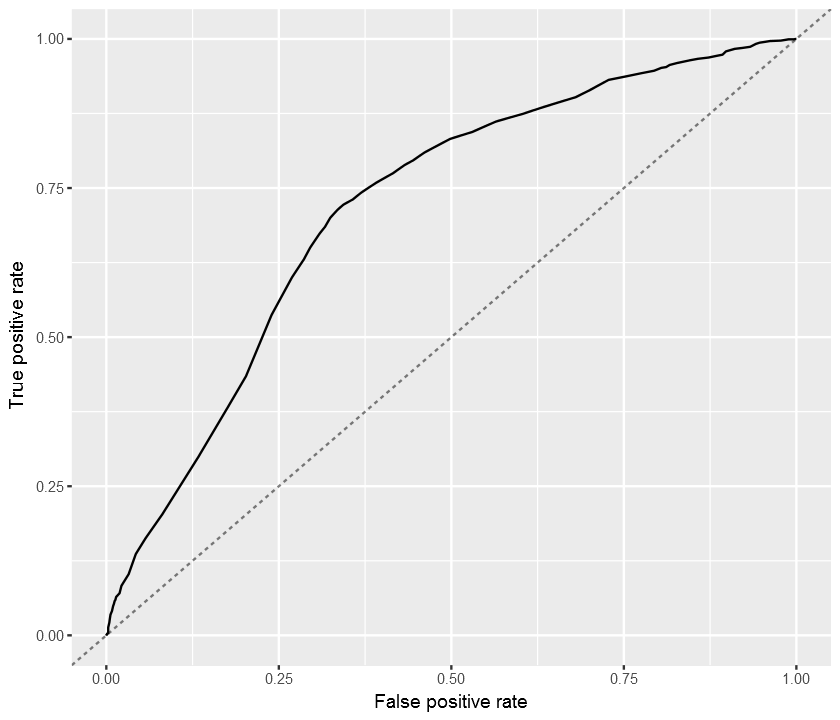

In [40]:
training.model = mlr::train(mlr.learner.xgb, mlr.task.training.ohe)
mlr.predict = predict(training.model, mlr.task.testing.ohe)
perf_ROC(mlr.predict)

#### 3.1.3 Random Forest (learner "ranger")

In [36]:
mlr.learner.ranger = makeLearner(
  "classif.ranger", 
  predict.type = "prob",
  num.trees = 1300,
  num.threads = detectCores() - 1,
  verbose = T
  )

        predicted
true       M Not_M -err.-
  M      804   640    640
  Not_M  502  1322    502
  -err.- 502   640   1142
       predicted
true    M         Not_M                        
  M     804       640       tpr: 0.56 fnr: 0.44
  Not_M 502       1322      fpr: 0.28 tnr: 0.72
        ppv: 0.62 for: 0.33 lrp: 2.02 acc: 0.65
        fdr: 0.38 npv: 0.67 lrm: 0.61 dor: 3.31


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio
      acc       tpr       tnr        f1       auc 
0.6505508 0.5567867 0.7247807 0.5847273 0.7065263 


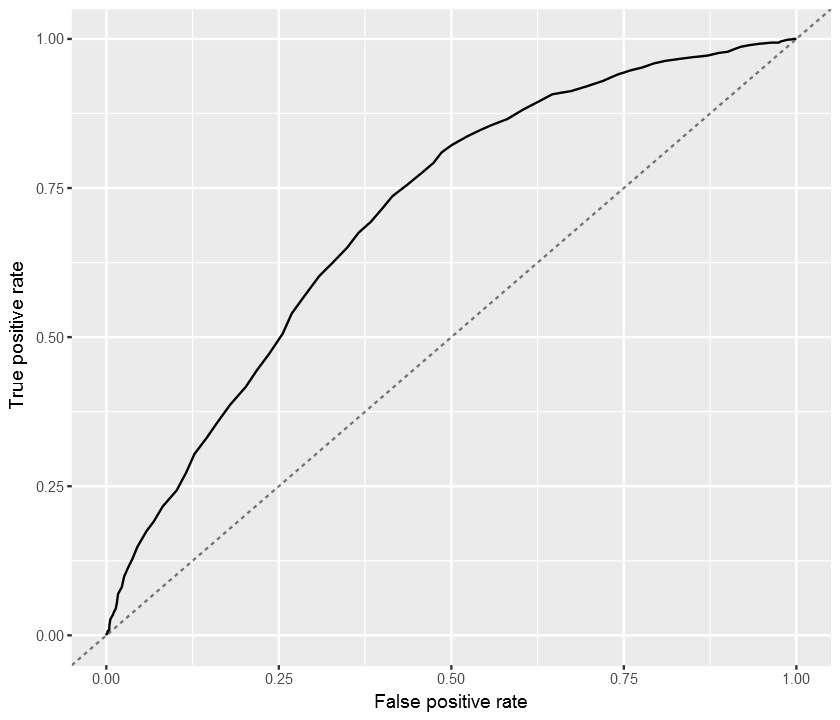

In [37]:
training.model = mlr::train(mlr.learner.ranger, mlr.task.training)
mlr.predict = predict(training.model, mlr.task.testing)
perf_ROC(mlr.predict)

#### 3.1.4 mrl ensemble

[1]	train-auc:0.675031 
Will train until train_auc hasn't improved in 10 rounds.

[101]	train-auc:0.692826 
[201]	train-auc:0.700526 
[300]	train-auc:0.707557 
        predicted
true       M Not_M -err.-
  M      927   517    517
  Not_M  541  1283    541
  -err.- 541   517   1058
       predicted
true    M         Not_M                        
  M     927       517       tpr: 0.64 fnr: 0.36
  Not_M 541       1283      fpr: 0.3  tnr: 0.7 
        ppv: 0.63 for: 0.29 lrp: 2.16 acc: 0.68
        fdr: 0.37 npv: 0.71 lrm: 0.51 dor: 4.25


Abbreviations:
tpr - True positive rate (Sensitivity, Recall)
fpr - False positive rate (Fall-out)
fnr - False negative rate (Miss rate)
tnr - True negative rate (Specificity)
ppv - Positive predictive value (Precision)
for - False omission rate
lrp - Positive likelihood ratio (LR+)
fdr - False discovery rate
npv - Negative predictive value
acc - Accuracy
lrm - Negative likelihood ratio (LR-)
dor - Diagnostic odds ratio
      acc       tpr       tnr      

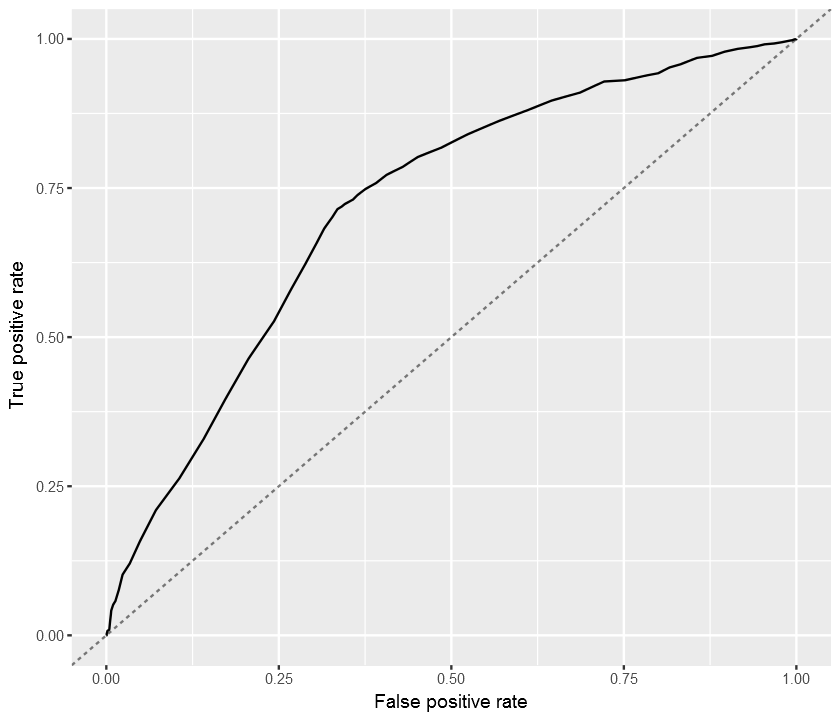

In [38]:
mlr.learners = list(mlr.learner.rpart, 
                    mlr.learner.xgb, 
                    mlr.learner.ranger)

mlr.learner.ensemble = makeStackedLearner(
  base.learners = mlr.learners, 
  predict.type = "prob", 
  method = "average"
  )

training.model.ensemble = mlr::train(mlr.learner.ensemble, mlr.task.training.ohe)
mlr.predict.ensemble = predict(training.model.ensemble, mlr.task.testing.ohe)

perf_ROC(mlr.predict.ensemble)

## References

<a id='de_livera1'></a> De Livera, A. M. (2010) [“Automatic forecasting with a modified exponential smoothing state space framework”](https://ideas.repec.org/p/msh/ebswps/2010-10.html), Monash Econometrics and Business Statistics Working Papers 10, no. 10.

<a id='de_livera2'></a> De Livera, A. M., Hyndman, R. J. and Snyder, R. D. (2011) [“Forecasting time series with complex seasonal patterns using exponential smoothing”](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771), Journal of the American Statistical Association 106, no. 496, pp. 1513-1527.

<a id='bischl'></a> Bischl, B., Lang, M., Kotthoff, L., Schiffner, J., Richter, J., Studerus, E., Casalicchio, G., Jones., Z. J. (2016) ["mlr: Machine Learning in R"](http://www.jmlr.org/papers/v17/15-066.html), Journal of Machine Learning Research 17, 1-5.


<a id='coghlan'></a> Coghlan, A. (2018) ["Welcome to a Little Book of R for Time Series!, Release 0.2"](https://a-little-book-of-r-for-time-series.readthedocs.io/en/latest/), Parasite Genomics Group, Wellcome Trust Sanger Institute, Cambridge, U.K.